In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

import sys
sys.path.append('resources')
import models

sns.set(style="whitegrid")

# Linear Regression

In a previous chapter we talked about how we can use the mean of a variable as a model of that variable. The logic was as follows:

1. We're going to pick a constant, $\beta_0$, as an estimate for any $y$.
2. We want this constant to minimize mean squared error: $\frac{1}{n} \sum (y - \beta_0)^2$ (MSE).
3. The mean, $\bar{y} = \frac{1}{n} \sum x_i$, minimizes MSE so use $\bar{y} = \beta_0$.

In terms of the previous section:

$$G = \frac{1}{n} \sum x_i$$

which returns:

$$f = \beta_0$$

which we use as:

$$\hat{y} = \beta_0$$

If we use $\beta_0$ as our model of $y$ then our estimates of $y$, $\hat{y}$,  will have an MSE equal to $\frac{1}{n} \sum (y - \beta_0)^2$ which is also the formula for variance, $\sigma^2$. We can express our model probabilistically as follows:

$$y \sim N(\beta_0, \sigma)$$

which says that $y$ is distributed normally with mean $\beta_0$ and error $\sigma$. Another way of looking at this is to separate out $\beta_0$. We can make this an equality:

$$y = N(\beta_0, \sigma)$$

and subtract $\beta_0$ from both sides we have:

$$y - \beta_0 = N(\beta_0, \sigma) - \beta_0$$
$$y - \beta_0 = N(0, \sigma)$$

then rearrange:

$$y = \beta_0 + N(0, \sigma)$$

While $N(0, \sigma)$ is often called "error", as we have seen, this is really just all the other things (the "known unknowns" and the "unknown unknowns") that influence $y$ but we are not taking into account. What we are saying here is that the mean is a "good" model for $y$ if our errors are normally distributed.

But it turns out we might be able to do better. What if all the unknowns aren't actually unknown? How can we include them?

Let's start by making a little synthetic data. We're going to generate both a $y$ and an $x$ but we're only going to use $y$ for right now.

In [4]:
np.random.seed(8472385)

In [5]:
data = {}
data["x"] = stats.norm.rvs(10.0, 1, 100)
data["e"] = stats.norm.rvs(0, 1, 100)
data["y"] = data["x"] * 2.5 + data["e"]
data = pd.DataFrame(data)

We'll start by plotting a histogram of $y$ to get a sense of its shape:

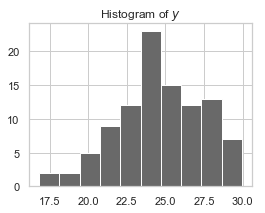

In [6]:
figure = plt.figure(figsize=(4,3))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.y,color="dimgray")
axes.set_title("Histogram of $y$")
plt.show()
plt.close()

Let's calculate the mean of $y$:

In [7]:
beta_0 = data.y.mean()
beta_0

24.638917684363282

which is our model of $y$, $\beta_0$. Graphically, it's something like this where values of $y$ are shown as dots and, $\beta_0$, the mean--our model--is shown as a red line:

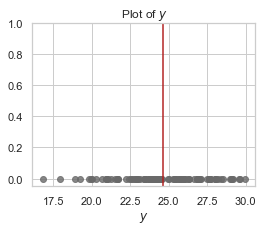

In [8]:
figure = plt.figure(figsize=(4,3))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data.y, [0] * data.y.size, color="dimgray", alpha=0.8)
axes.axvline(beta_0, color="firebrick")
axes.set_xlabel(r"$y$")
axes.set_ylim((-0.05, 1))
axes.set_title(r"Plot of $y$")

plt.show()
plt.close()

By convention, we often show the *target* variable on the y-axis:

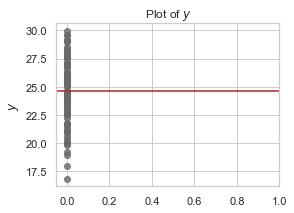

In [9]:
figure = plt.figure(figsize=(4,3))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( [0] * data.y.size, data.y, color="dimgray", alpha=0.8)
axes.axhline(beta_0, color="firebrick")
axes.set_xlim((-0.05, 1))
axes.set_ylabel(r"$y$")
axes.set_title(r"Plot of $y$")

plt.show()
plt.close()

Let's calculate the "error" of this model:

In [10]:
data["error"] = data.y - beta_0

and show a histogram of it:

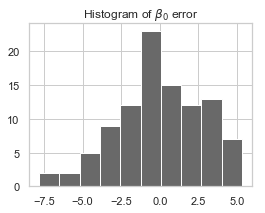

In [11]:
figure = plt.figure(figsize=(4,3))
axes = figure.add_subplot(1, 1, 1)
axes.hist(data.error,color="dimgray")
axes.set_title(r"Histogram of $\beta_0$ error")
plt.show()
plt.close()

This is an empirical application of our derivation above. The errors are centered at zero (which we expect given the formulas for the mean on the one hand and the formulas for variance and MSE on the other hand). The empirical distribution is not quite normal and that may be okay for our purposes. This is what we mean by "is the normal distribution a good model for this data" but let's put that to the side for now. Ideally, the errors are normally distributed with $y$'s standard deviation (variance):

In [12]:
stdev = data.y.std()
print(stdev)

2.809849407158323


Let's plot the idealized case:

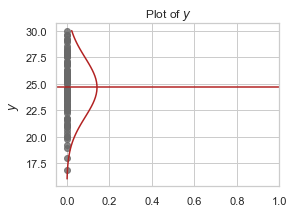

In [13]:
figure = plt.figure(figsize=(4,3))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( [0] * data.y.size, data.y, color="dimgray", alpha=0.8)
axes.axhline(beta_0, color="firebrick")
ys = np.linspace(16, 30)
xs = [stats.norm.pdf( k, loc=beta_0, scale=stdev) for k in ys]
axes.plot( xs, ys, color="firebrick")
axes.set_xlim((-0.05, 1))
axes.set_ylabel(r"$y$")
axes.set_title(r"Plot of $y$")

plt.show()
plt.close()

Now we're ready to introduce "better". The basic idea is to replace $\beta_0$ with a linear function. Instead of:

$$y = \beta_0 + N(0, \sigma)$$

we have:

$$y = \beta_0 + \beta_1 x_1 + N(0, \sigma)$$

in the case of *univariate* ("one variable") linear regression. As we have seen, another way to look at this is:

$$y \sim N(\beta_0 + \beta_1 x_1, \sigma)$$

So basically, we're saying $y$ is normally distributed with a mean equal to this *function* of one variable, $x_1$, with "error" (I like "noise") equal to $N(0, \sigma)$. We often refer to $N(0, \sigma)$ as $\epsilon$. So you will often see:

$$y = \beta_0 + \beta_1 x_1 + \epsilon$$

as well.

## Implementation

Python is a general purpose language so it doesn't just happen to have regression built in. However, there are Python libraries with linear regression implementations. Here are a few options:

1. [scikit-learn](http://scikit-learn.org/)
2. [statsmodels](http://statsmodels.sourceforge.net/)
3. [scipy](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html)

Since we're going to be working a bit with scikit-learn throughout the book, we're going to start using it now even though we could probably get by with the included scipy library. It's nice to know there are other options.

We're also going to use a library called [patsy](https://github.com/pydata/patsy) to save us some typing. Patsy permits us to describe our linear models using an R-like formula syntax.

We'll wrap both of these libraries in a function called `linear_regression`. The main reason for this is that the `scikit-learn` library has a machine learning focus so that it returns *no* metrics about the regression. This is in contrast to the `statsmodels` library that returns the model along with standard Frequentist metrics (and incorrectly, I might add).

Because we do want *some* (Bayesian) evaluation of the linear regression, we'll need to customize our results, which we will do in stages. For now, let's not worry about inference. The `linear_regression` function in the `models` module of the book's code (in the `resources`) directory, will work. It runs most of the information we need including:

1. the model from Scikit Learn in case we need it.
2. the formula used to fit the model.
3. the coefficients for the features.
4. the $\sigma$ (error) of the regression.
5. the $R^2$ of the regression or the coefficient of determination. $R^2$ is literally the Pearson correlation coefficient squared thus, unlike the Pearson correlation coefficient, it is never negative. It has several interpretations:
    1. The percent of the variability explained by the model.
    2. The improvement of the model over the constant model (see below).
    3. The square of correlation (as we just mentioned).

## Linear Regression with a Numerical Variable (Synthetic Data)

We begin our introduction to univariate linear regression looking at a single numerical feature, $x$. But first, let's think about what our current (mean) model means in the context of another variable like $x$

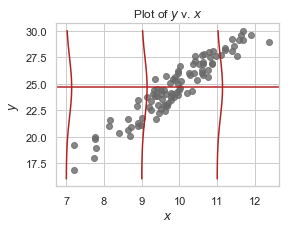

In [14]:
figure = plt.figure(figsize=(4,3))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data.x, data.y, color="dimgray", alpha=0.8)
axes.axhline(beta_0, color="firebrick")

ys = np.linspace(16, 30)
xs = [stats.norm.pdf( k, loc=beta_0, scale=stdev) + 7 for k in ys]
axes.plot( xs, ys, color="firebrick")

xs = [stats.norm.pdf( k, loc=beta_0, scale=stdev) + 9 for k in ys]
axes.plot( xs, ys, color="firebrick")

xs = [stats.norm.pdf( k, loc=beta_0, scale=stdev) + 11 for k in ys]
axes.plot( xs, ys, color="firebrick")

axes.set_ylabel(r"$y$")
axes.set_xlabel(r"$x$")
axes.set_title(r"Plot of $y$ v. $x$")

plt.show()
plt.close()

Essentially we are saying, no matter what $x$ is, we predict $\beta_0$. This is the red line. It is actually a linear model but not necessarily a good one! The error of the model for different values of $x$ can be visualized by showing normally distributed error overlayed on $x$. We'll see how a linear regression model changes this.

We fit our first model:

$$\hat{y} = \beta_0 + \beta_1 x$$

or

$$y = \beta_0 + \beta_1 x + \epsilon$$

Notice the slight difference between the two formulations. The estimate $\hat{y}$ lacks the "noise", whereas the real value includes it. 

In Patsy, this is expressed as $y \sim x$:

In [15]:
results = models.linear_regression("y ~ x", data)

We can use `simple_describe_lr` to show a "nice" table of results:

In [16]:
print(models.simple_describe_lr(results))

Model: y ~ x
------------  ---------  -----
Coefficients             Value
              $\beta_0$  -0.48
x             $\beta_1$  2.54

Metrics       Value
$\sigma$      0.92
$R^2$         0.89
------------  ---------  -----


(Note: the actual nice tables are temporarily turned off.
They show up well in the Notebook and as HTML but when the PDF is generated, they look awful.
We're stuck with ASCII tables until I can get it fixed.)


We'll return to the coefficients shortly. The $\sigma$ is the standard deviation of our predictions (strangely, it's closer to error than MSE is because it's not squared). The coefficient of determination ($R^2$), as previously mentioned, has several related interpretations:

1. The model explains 89.4% of the variability in $y$.
2. The model is better than the $\beta_0$ only model (here $R^2$ is just an index of "better" from 0 to 1).
3. The correlation between $y$ and the feature(s) is 89.4%.

We will generally pick explanation #1 but you should be aware of the others. 

Here, the model explains 89% of the variation of $y$. This is generally considered excellent but there are many caveats. We'll return to estimation and evaluation later in this chapter and in the next two chapters. For now, we just want to understand what the overall model *means*. In the next section, we'll start to interpret the coefficients as well.

The estimated formula is:

$$\hat{y} = -0.48 + 2.54x$$

which we can plot:

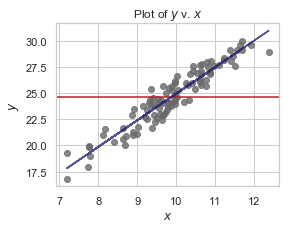

In [17]:
figure = plt.figure(figsize=(4,3))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data.x, data.y, color="dimgray", alpha=0.8)

axes.axhline(beta_0, color="firebrick")

beta = results[ "coefficients"]
axes.plot(data.x, [beta[ 0] + beta[ 1] * x for x in data.x], '-', color="midnightblue", alpha=0.75)

axes.set_ylabel(r"$y$")
axes.set_xlabel(r"$x$")
axes.set_title(r"Plot of $y$ v. $x$")

plt.show()
plt.close()

For comparison, we show the old model (the mean of $y$) in red and the new model (linear regression $y = -0.48 + 2.54x$) in blue. You can always use the mean as a baseline model.

As we noted above, a few mathematical identities allow us to equate the standard deviation as at least being proportional to the MSE. For the mean, the standard deviation was 2.81. For the linear regression, the standard deviation ($\sigma$) is 0.91. What about that error? We showed it before for the mean only model. What about the linear regression?

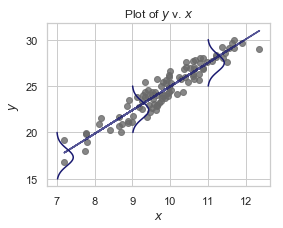

In [18]:
figure = plt.figure(figsize=(4,3))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data.x, data.y, color="dimgray", alpha=0.8)

beta = results[ "coefficients"]
axes.plot(data.x, [beta[ 0] + beta[ 1] * x for x in data.x], '-', color="midnightblue", alpha=0.75)

ys = np.linspace(15, 20)
xs = [stats.norm.pdf( k, loc=beta[ 0] + beta[ 1] * 7, scale=results["sigma"]) + 7 for k in ys]
axes.plot( xs, ys, color="midnightblue")

ys = np.linspace(20, 25)
xs = [stats.norm.pdf( k, loc=beta[ 0] + beta[ 1] * 9, scale=results["sigma"]) + 9 for k in ys]
axes.plot( xs, ys, color="midnightblue")

ys = np.linspace(25, 30)
xs = [stats.norm.pdf( k, loc=beta[ 0] + beta[ 1] * 11, scale=results["sigma"]) + 11 for k in ys]
axes.plot( xs, ys, color="midnightblue")

axes.set_ylabel(r"$y$")
axes.set_xlabel(r"$x$")
axes.set_title(r"Plot of $y$ v. $x$")

plt.show()
plt.close()

Remember when we overlayed the error on the constant mean model? Here we can see that the error is smaller and tight around the regression line. This fully encompasses what we mean by:

$$y = -0.48 + 2.54 x + N(0, 0.91)$$

## Linear Regression with a Numerical Feature (Actual Data)

Now we're going to look at two variables from a real data. We have some data about child IQ as well as some possible explanatory features including the IQs and education of their mothers. We have a sense that there is a relationship here and we want to build a linear regression model of it. We assume that all the previous steps (ASK, GET, EXPLORE) have been completed.

In [19]:
child_iq = pd.read_csv( "resources/child_iq.tsv", sep="\t")

Although for now we're only interested in one variable, let's look at the data types and data examples:

In [20]:
child_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
child_iq    434 non-null int64
mom_hs      434 non-null int64
mom_iq      434 non-null float64
mom_work    434 non-null int64
mom_age     434 non-null int64
dtypes: float64(1), int64(4)
memory usage: 17.0 KB


We have 434 observations with no null values. The variables are as follows:

* **child_iq** - numeric, the child's IQ.
* **mom_hs** - boolean, whether or not the mother finished HS.
* **mom_iq** - numeric, the mother's IQ.
* **mom_work** - categorical, whether and how much the mother works.
* **mom_age** - numeric, the mother's age.

### Side Note on "Features"

There is not always a one to one relationship between the *variables* in the data and *features* in our model. For example, you might have a variable like *mom_age* your data but you might want to include both $mom\_age$ and $\sqrt{mom\_age}$ as features in your model (for reasons we'll talk about later).

Let's look at some actual data:

In [21]:
child_iq.head()

,child_iq,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27


Now's the time to start bringing in our Causal Loop Diagrams. So far, our models have been something like this:

![Child IQ](resources/child_cld01.png){width="10%"} 

That is, we only looked at a single target variable and sought to model that target variable only in terms of itself. Now we can try to use other variables, although in this chapter we're only going to use one variable. More importantly, however, is that when we created the causal loop diagram, we put a "+" or "-" on the arrow to indicate a positive or negative relationship. When we estimate the model, our $\beta_1$ should similarly be "+" or "-".

Think about it. What do you expect the relationship between the mother's IQ and the child's IQ to be?

![Child IQ and Mother's IQ](resources/child_cld02.png){width="25%}

It's a good idea to get a sense of the baseline model:

In [22]:
print("child_iq = {0} ({1})".format(child_iq.child_iq.mean(), child_iq.child_iq.std()))

child_iq = 86.79723502304148 (20.410688494227184)


This basically says that if we used the mean (86.8) to predict any given child's IQ, the standard deviation of our estimates would be 20.4 IQ points.

Let's estimate the linear model:

In [23]:
result1 = models.linear_regression( "child_iq ~ mom_iq", data = child_iq)
print(models.simple_describe_lr(result1))

Model: child_iq ~ mom_iq
------------  ---------  -----
Coefficients             Value
              $\beta_0$  25.80
mom_iq        $\beta_1$  0.61

Metrics       Value
$\sigma$      18.27
$R^2$         0.20
------------  ---------  -----


The model is:

$$\hat{child_iq} = 25.8 + 0.61 mom\_iq$$

The $R^2$ is not fantastic but this is real life and real data. Our model explains only 20% of the variation in $y$. This is understandable since we're only trying to use one variable in what is clearly a multivariate process probably full of "unknown unknowns".

The standard deviation of our estimate has only dropped to 18.3 IQ points from 20.4.

Let's plot data and the model:

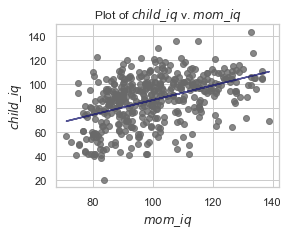

In [24]:
figure = plt.figure(figsize=(4,3))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( child_iq.mom_iq, child_iq.child_iq, color="dimgray", alpha=0.8)

beta = result1[ "coefficients"]
axes.plot(child_iq.mom_iq, [beta[ 0] + beta[ 1] * x for x in child_iq.mom_iq], '-', color="midnightblue", alpha=0.75)

axes.set_ylabel(r"$child\_iq$")
axes.set_xlabel(r"$mom\_iq$")
axes.set_title(r"Plot of $child\_iq$ v. $mom\_iq$")

plt.show()
plt.close()

## Interpreting Linear Regression

There are many different ways to interpret linear regression, which is to say, the $\beta$s.

The *causal* interpretation of $\beta_i$ (where $i > 0$) goes something like this: if you increase $x_i$ by 1 then $y$ increases by $\beta_i$, other things being equal.  The causal interpretation can lead to some silliness when the relationship is only associative and not actually causal. For example, in the current case, you can't increase a child's IQ by increasing the mother's IQ. This leads to the predictive interpretation.

The *predictive* interpretation can be more difficult to understand so let's use the current example: $\beta_1$ is the expected difference in IQ between children whose mothers had an IQ of 80 and children whose mothers had an IQ of 81, in this case, 0.61 IQ points. This takes a little getting used to because it's not the interpretation we generally hear. However, it is consistent with our derivation of linear regression as replacing a constant ($\beta_0$) value for the mean with a *function* ($\beta_0 + \beta_1 x$). Thus our model says, given a value for $mom\_iq=80$, what is the mean value of $child\_iq$ *for those children*?

$\hat{child\_iq} = 25.8 + 0.61 mom\_iq$

$\hat{child\_iq} = 25.8 + 0.61 \times 80$

$\hat{child\_iq} = 25.8 + 48.8$

$\hat{child\_iq} = 25.8 + 48.8$

$\hat{child\_iq} = 74.6$

Overall, this leads to a smaller error than just estimating using the overall mean of 86.8 (although not much of a decrease in error). We will generally try to use the predictive interpretation but the causal interpretation is just so much easier to say. We just have to be careful when the interpretation is at odds with what is actually possible for the real world process.

## What about the intercept?

We haven't mentioned $\beta_0$ yet. It's worth noting that the $\beta_0$ from our original mean only model and the $\beta_0$ from our linear regression are not the same. The mean has now been replaced by a function. So what is $\beta_0$? From a purely mathematical point of view, it's the value of $y$ when $x = 0$. The problem is that $x=0$ may not be a legitimate value for $x$ and so $\beta_0$ has no real or useful interpretation. In this case, the mother cannot have an IQ of 0 so the intercept is meaningless.

There are ways to transform the data so that the intercept *does* have a meaningful interpretation and we'll talk about those later.

It's worth noting that this is just a special case of a more general problem: prediction outside the observed values of $x$. Generally speaking, you should use your model to make predictions for values of the features that you did not observe in the data set. This is where the model is likely to be weak and will likely be weaker the farther $x$ is from the observed minimum or maximum when the model was built. $mom\_iq = 0$ is just a very extreme case of this.

This also makes sense in the context of the predictive interpretation of linear regression. If you didn't observe many (or any) values, you probably shouldn't trust your model's prediction of their *mean*.

## Linear Regression and a Binary  Feature (Actual Data)

As we will see over the course of this and the next chapter, linear regression is fairly flexible. It will take any feature numerical feature and spit out a model. This can be problematic if you don't think about a little bit about what the feature and what the coefficient might *mean*.

For example, we know that the linear regression algorithm ($G$) won't accept strings as inputs. There's no way to have a feature that's ["yes", "no", "no", "yes", "no"] and have the algorithm work. However, it will work with binary features (categorical variables with two value *codes*) such as [1, 0, 0, 1, 0]. This is the case we're going to look at right shortly. The variable is $mom\_hs$ which indicates whether (1) or not (0) the mother went to high school. In regression, these variables are often called "indicator variables" for this reason.

However, if we have an encoding of $\{0, 1, 2, 3\}$ for some categorical feature although this will "work" in the sense that $G$ won't fail, the resulting model is questionable because "2" in this case isn't actually twice "1" and therefore it's not clear what the coefficient means. 

This will happen if the feature is *ordered* as well. Suppose we use the *place* that someone finished in a marathon as a feature. Because 16th place isn't twice 8th place, this can lead to problems. It would be better in this case to use the finish time as a feature instead. In that case, if it took 16th place twice as long to finish as 8th place, that *would* make sense.

For categorical features of more than two values, what we generally do in use a "one hot" encoding. We'll talk about this later. Let's return to the simple binary feature case, $mom\_hs$, and our model: $child\_iq \sim mom\_hs$:

In [25]:
result2 = models.linear_regression("child_iq ~ mom_hs", data=child_iq)

In [26]:
print(models.simple_describe_lr(result2))

Model: child_iq ~ mom_hs
------------  ---------  -----
Coefficients             Value
              $\beta_0$  77.55
mom_hs        $\beta_1$  11.77

Metrics       Value
$\sigma$      19.85
$R^2$         0.06
------------  ---------  -----


This model is not even quite as good as the last one but for our purposes what is more important is what it all means. The model is:

$\hat{y} = 77.5 + 11.8 mom\_hs$

but $mom\_hs$ can only take on two values: 0 or 1 so we either have:

$\hat{y} = 77.5 + 11.8 mom\_hs$

$\hat{y} = 77.5 + 11.8 \times 0$

$\hat{y} = 77.5$

if the mother did not complete high school or:

$\hat{y} = 77.5 + 11.8 mom\_hs$

$\hat{y} = 77.5 + 11.8 \times 1$

$\hat{y} = 77.5 + 11.8$

$\hat{y} = 89.3$

if the mother did complete high school. In essence, for single binary feature like $mom\_hs$, the linear regression model is equivalent to calculating the mean for each of the groups separately:

In [27]:
grouped = child_iq.groupby("mom_hs")
grouped["child_iq"].describe()

,count,mean,std,min,25%,50%,75%,max
mom_hs,,,,,,,,
0,93.0,77.548387,22.573800,20.0,58.0,80.0,95.0,136.0
1,341.0,89.319648,19.049483,38.0,77.0,92.0,103.0,144.0


We can see that the means in the table above are the same that we calculated using our linear regression model. So linear regression doesn't really *calculate* with categorical features. It "handles" them by separating them into different groups. (The equivalency of the calculations only holds in this simple case, once you introduce additional features, the analogy breaks down).

Let's "plot" the data:

77.5483870967742


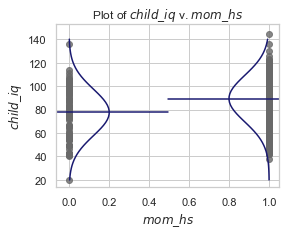

In [28]:
figure = plt.figure(figsize=(4,3))

beta = result2[ "coefficients"]

axes = figure.add_subplot(1, 1, 1)
axes.scatter([0] * child_iq[child_iq.mom_hs == 0].child_iq.size, child_iq[child_iq.mom_hs == 0].child_iq, color="dimgray", alpha=0.8)
axes.axhline(beta[0], xmax=0.5,color="midnightblue")

axes.scatter([1] * child_iq[child_iq.mom_hs == 1].child_iq.size, child_iq[child_iq.mom_hs == 1].child_iq, color="dimgray", alpha=0.8)
axes.axhline(beta[0] + beta[1], xmin=0.5, color="midnightblue")

ys = np.linspace(20, 140)
xs = [stats.norm.pdf( k, loc=beta[0], scale=result2["sigma"]) * 10 for k in ys]
axes.plot( xs, ys, color="midnightblue")
print(beta[0])
ys = np.linspace(20, 140)
xs = [1.0 - stats.norm.pdf( k, loc=beta[0] + beta[1], scale=result2["sigma"]) * 10 for k in ys]
axes.plot( xs, ys, color="midnightblue")


axes.set_ylabel(r"$child\_iq$")
axes.set_xlabel(r"$mom\_hs$")
axes.set_title(r"Plot of $child\_iq$ v. $mom\_hs$")

plt.show()
plt.close()

Here we can see that our model represents two mean values (one for the mother's who did not complete high school and one for the mothers that did). The standard deviation is the same for both because it's the same for the model overall. Note that this is different than what happened above when we calculated the individual means and standard deviations.

This case isn't particularly compelling except that it drives home the idea that linear regression is simply a model of the mean as a function and it sets us up for the next case, the only time we'll have two variables in this chapter.

## Linear Regression with a Numerical Feature and Binary Feature

In this section we will see the various ways that a numerical feature and a binary feature (indicator variable) can be combined. This is in anticipation of the next chapter were we look at multivariate models in general.

We can combine the two models above in a number of ways:

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_hs + \beta_2 mom\_iq$

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_iq + \beta_2 mom\_iq \times mom\_hs$

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_hs + \beta_2 mom\_iq + \beta_3 mom\_iq \times mom\_hs$

Let's take the simplest case first.

### Numerical Feature and Binary Feature

Remember that $mom\_hs$ can only take on two values: 0 or 1. This means that the following equation:

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_hs + \beta_2 mom\_iq$

only has two possibilities as far as $mom\_hs$ is concerned. It can either be:

$\hat{child\_iq} = \beta_0 + \beta_1 (mom\_hs = 0) + \beta_2 mom\_iq$

$\hat{child\_iq} = \beta_0 + \beta_1 \times 0 + \beta_2 mom\_iq$

$\hat{child\_iq} = \beta_0 + \beta_2 mom\_iq$

when $mom\_hs$ is 0 or it can be:

$\hat{child\_iq} = \beta_0 + \beta_1 (mom\_hs = 1) + \beta_2 mom\_iq$

$\hat{child\_iq} = \beta_0 + \beta_1 \times 1 + \beta_2 mom\_iq$

$\hat{child\_iq} = (\beta_0 + \beta_1) + \beta_2 mom\_iq$

when $mom\_hs$ is 1. As we saw before, the presence of the binary variable "automagically" creates two models, one for each value. Now let's estimate this model with the $child\_iq$ data:

In [29]:
result3 = models.linear_regression("child_iq ~ mom_hs + mom_iq", data=child_iq)
print(models.simple_describe_lr(result3))

Model: child_iq ~ mom_hs + mom_iq
------------  ---------  -----
Coefficients             Value
              $\beta_0$  25.73
mom_hs        $\beta_1$  5.95
mom_iq        $\beta_2$  0.56

Metrics       Value
$\sigma$      18.14
$R^2$         0.21
------------  ---------  -----


Looking at our metrics, the proportion of variation in $child\_id$ explained by the model is about 21.4%. The standard error of the regression is 18.1 IQ points.

We can use our calculations above and insert the values of $\beta_0$, $\beta_1$, and $\beta_2$. The equation when the mother did not graduate high school is:

$\hat{child\_iq} = \beta_0 + \beta_2 mom\_iq$

$\hat{child\_iq} = 25.7 + 0.56 mom\_iq$

and the equation for when she *did* graduate high school is:

$\hat{child\_iq} = (\beta_0 + \beta_1) + \beta_2 mom\_iq$

$\hat{child\_iq} = (25.7 + 6.0) + 0.56 mom\_iq$

$\hat{child\_iq} = 31.7 + 0.56 mom\_iq$

Graphically, there are two lines, one for each case:



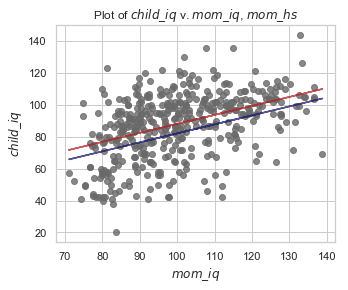

In [30]:
figure = plt.figure(figsize=(5,4))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( child_iq.mom_iq, child_iq.child_iq, color="dimgray", alpha=0.8)

beta = result3[ "coefficients"]
axes.plot(child_iq.mom_iq, [beta[ 0] + beta[ 2] * x for x in child_iq.mom_iq], '-', color="midnightblue", alpha=0.75)
axes.plot(child_iq.mom_iq, [(beta[ 0] + beta[1]) + beta[ 2] * x for x in child_iq.mom_iq], '-', color="firebrick", alpha=0.75)

axes.set_ylabel(r"$child\_iq$")
axes.set_xlabel(r"$mom\_iq$")
axes.set_title(r"Plot of $child\_iq$ v. $mom\_iq$, $mom\_hs$")

plt.show()
plt.close()

When the indicator variable is 1, the entire regression line shifts (up in this case because $\beta_1$ is positive).

### Numerical Feature and Binary Feature Interaction Term

The second model removes $mom\_hs$ by itself and adds the product of $mom\_iq$ and $mom\_hs$. This is called an "interaction term" because it captures the "interaction" of the two variables. Mathematically, we start with the following:

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_iq + \beta_2 mom\_iq \times mom\_hs$

and when $mom\_hs$ is 0, we have:

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_iq + \beta_2 mom\_iq \times (mom\_hs = 0)$

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_iq + \beta_2 mom\_iq \times 0$

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_iq$

which is our regression line without $mom\_hs$. If $mom\_hs$ is 1, then we have:

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_iq + \beta_2 mom\_iq \times (mom\_hs = 1)$

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_iq + \beta_2 mom\_iq \times 1$

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_iq + \beta_2 mom\_iq$

$\hat{child\_iq} = \beta_0 + (\beta_1 + \beta_2) mom\_iq$

which, as you might imagine, adjusts the *slope* of the line when the mother has completed high school. Let's estimate this model. The Patsy code for an interaction term is "x1:x2".


In [31]:
result4 = models.linear_regression("child_iq ~ mom_iq + mom_hs:mom_iq", data=child_iq)
print(models.simple_describe_lr(result4))

Model: child_iq ~ mom_iq + mom_hs:mom_iq
-------------  ---------  -----
Coefficients              Value
               $\beta_0$  29.77
mom_iq         $\beta_1$  0.53
mom_hs:mom_iq  $\beta_2$  0.05

Metrics        Value
$\sigma$       18.18
$R^2$          0.21
-------------  ---------  -----


The $R^2$ still isn't great but this is illustrative, we're not trying to settle the origins of IQ here.

We can fill in these values and, for $mom\_hs = 0$ we have:

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_iq$

$\hat{child\_iq} = 29.8 + 0.53 mom\_iq$

and for $mom\_hs = 1$, we have:

$\hat{child\_iq} = \beta_0 + (\beta_1 + \beta_2) mom\_iq$

$\hat{child\_iq} = 29.8 + (0.53 + 0.05) mom\_iq$

$\hat{child\_iq} = 29.8 + 0.58 mom\_iq$

Graphically, this is as follows:

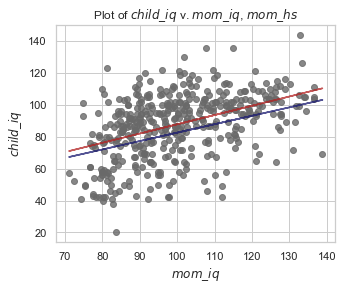

In [32]:
figure = plt.figure(figsize=(5,4))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( child_iq.mom_iq, child_iq.child_iq, color="dimgray", alpha=0.8)

beta = result4[ "coefficients"]
axes.plot(child_iq.mom_iq, [beta[ 0] + beta[ 1] * x for x in child_iq.mom_iq], '-', color="midnightblue", alpha=0.75)
axes.plot(child_iq.mom_iq, [beta[ 0] + (beta[1] + beta[ 2]) * x for x in child_iq.mom_iq], '-', color="firebrick", alpha=0.75)

axes.set_ylabel(r"$child\_iq$")
axes.set_xlabel(r"$mom\_iq$")
axes.set_title(r"Plot of $child\_iq$ v. $mom\_iq$, $mom\_hs$")

plt.show()
plt.close()

They have the same intercept but very slightly different slopes.

### Both

Of course, as we saw in the 3rd equation, we can combine both of these. We will speak more about interaction terms in the next chapter. If we start with the full equation:

$\hat{child\_iq} = \beta_0 + \beta_1 mom\_hs + \beta_2 mom\_iq + \beta_3 mom\_iq \times mom\_hs$

and set $mom\_hs$ to zero, we end up with a simplified version:

$\hat{child\_iq} = \beta_0 + \beta_2 mom\_iq$

If, however, $mom\_hs = 1$, then we end up shifting both the intercept and the slope:

$\hat{child\_iq} = (\beta_0 + \beta_1) mom\_hs + (\beta_2 + \beta_3) mom\_iq$

Let's estimate this model:

In [33]:
result5 = models.linear_regression("child_iq ~ mom_hs + mom_iq + mom_hs:mom_iq", data=child_iq)
print(models.simple_describe_lr(result5))

Model: child_iq ~ mom_hs + mom_iq + mom_hs:mom_iq
-------------  ---------  ------
Coefficients              Value
               $\beta_0$  -11.48
mom_hs         $\beta_1$  51.27
mom_iq         $\beta_2$  0.97
mom_hs:mom_iq  $\beta_3$  -0.48

Metrics        Value
$\sigma$       17.97
$R^2$          0.23
-------------  ---------  ------


The $R^2$ went up just a little bit. We'll talk more about that later. $R^2$ is a non-decreasing function of the number of features in the model. This means that adding another feature will not (generally) hurt the model and will probably help even if the feature doesn't belong there!

Substituting into our equations above, we have (for children whose mothers that did not graduate high school):

$\hat{child\_iq} = \beta_0 + \beta_2 mom\_iq$

$\hat{child\_iq} = -11.48 + 0.97 mom\_iq$

and for when mothers did graduate high school ($mom\_hs=1$):

$\hat{child\_iq} = (\beta_0 + \beta_1) mom\_hs + (\beta_2 + \beta_3) mom\_iq$

$\hat{child\_iq} = (-11.48 + 51.3) + (0.97 - 0.48) mom\_iq$

$\hat{child\_iq} = (-11.48 + 51.3) + (0.97 - 0.48) mom\_iq$

$\hat{child\_iq} = 39.82 + 0.49 mom\_iq$

How are we to interpret these models? For children whose mothers did not graduate high school, the base IQ starts low and increases fairly fast (nearly 1 to 1) for each IQ point of the mother. For children whose mothers did graduate high school, the base IQ start higher and only increases about 1 for every 2 IQ points of the mother. Graphically,

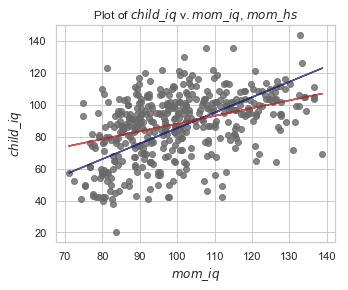

In [34]:
figure = plt.figure(figsize=(5,4))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( child_iq.mom_iq, child_iq.child_iq, color="dimgray", alpha=0.8)

beta = result5[ "coefficients"]
axes.plot(child_iq.mom_iq, [beta[ 0] + beta[ 2] * x for x in child_iq.mom_iq], '-', color="midnightblue", alpha=0.75)
axes.plot(child_iq.mom_iq, [(beta[ 0] + beta[1]) + (beta[ 2] + beta[3]) * x for x in child_iq.mom_iq], '-', color="firebrick", alpha=0.75)

axes.set_ylabel(r"$child\_iq$")
axes.set_xlabel(r"$mom\_iq$")
axes.set_title(r"Plot of $child\_iq$ v. $mom\_iq$, $mom\_hs$")

plt.show()
plt.close()

It's almost like there are two models (although the results are not quite the same as if you had estimated them separately because the two "models" share a common $\sigma$, which is jointly minimized).

## Bayesian Inference with the Bootstrap

As is true of all our modeling efforts, the data we observed is consistent with a wide variety of different parameter values. Although in the context of $y$, we take the $\beta$s as given, they are just estimates. Although we would be correct to say:

$\hat{y} = \hat{\beta_0} + \hat{\beta_1} x$

nobody does ("we estimate with estimates").

We can use our domain knowledge to interpret the coefficients in context but we need something else to determine how credible the coefficients are.

In order to determine credibility bounds, we can once again turn to Bayesian inference. Unfortunately, Bayesian inference is more complicated with these more complicated models but, as before, the Bootstrap comes to the rescue. We can generate bootstrap samples from our data, fit our model to each sample, and use those estimates to generate posterior distributions for the coefficients.

Not only that, we can do a bit better than Frequentist statistics and generate posterior distributions for metrics such as $\sigma$ and $R^2$.

In [35]:
result6 = models.bootstrap_linear_regression("child_iq ~ mom_hs + mom_iq + mom_hs:mom_iq", data=child_iq)
print(models.describe_bootstrap_lr(result6))

Model: child_iq ~ mom_hs + mom_iq + mom_hs:mom_iq
-------------  ---------  ------  -------  -----
                                  95% BCI
Coefficients              Mean    Lo       Hi
               $\beta_0$  -11.48  -36.86   15.67
mom_hs         $\beta_1$  51.27   21.71    82.11
mom_iq         $\beta_2$  0.97    0.68     1.25
mom_hs:mom_iq  $\beta_3$  -0.48   -0.82    -0.15

Metrics        Mean       Lo      Hi
$\sigma$       17.97      16.99   19.25
$R^2$          0.23       0.19    0.30
-------------  ---------  ------  -------  -----


How do we interpret these (Bayesian) Credible Intervals? Just as we did before. The estimated value of $\beta_0$ is -11.48 but there is a 95% probability that the value is between -44.1 and 12.1. The estimated value of $\beta_1$ is 52.3 but there is a 95% probability that the value is between 18.9 and 89.6. The estimated value of $\beta_2$ is 0.97 but there is a 95% probability the value is between 0.72 and 1.31. Finally, we estimated the value of $\beta_3$ as -0.48 but there is a 95% probability that the value is between -0.89 and -0.16.

The width of these bounds is some indication of why our model is so poor. But we will leave it at that for now. In traditional terms, there is only one coefficient whose credible interval contains zero but it is the intercept so it isn't cause for concern.

We can also ask better questions than just "is this coefficient zero or not zero?". If we started with a Causal Loop Diagram, we know what we expect the signs on the coefficients to be. For example, perhaps we expect $mom\_hs = 1$ to be a general overall boost to the prediction of the child's IQ regardless of the mother's *measured* IQ. Understanding what this means in terms of the model we have chosen (linear regression) then our expectation is that $\beta_1 + \beta_0 > \beta_0$ or that $\beta_1 > 0$. We can answer that question. Based on the data, what is the probability that $\beta_1$ is positive?

In [36]:
print('P(mom_hs = 1 > 0)', np.mean(result6['resampled_coefficients']['mom_hs'] > 0))

P(mom_hs = 1 > 0) 1.0


Based on the data, the conjecture has a probability of 99%. And similarly, for the slope. We generally believe that the child's IQ will, on average, increase with the mother's IQ. This seems perfectly reasonable. We do have to be careful though with "regression to the mean". Linear regression got its name from the phenomena identified by Galton. He noted that adults with above average heights tended to have children with average heights and adults with below average heights tended to have children with average heights.

We should then expect that above average IQs would lead to average IQs and similarly for below average IQs. Still, the slope is not going to be *negative*:

In [37]:
print('P(mom_hs = 1 > 0)', np.mean(result6['resampled_coefficients']['mom_iq'] > 0))

P(mom_hs = 1 > 0) 1.0


And here we can see that, based on the data, we can be nearly certain that there is a positive relationship between the mother's IQ and the child's.

Additionally, we have credible bounds on the error of the regression ($\sigma$) as 16.8 to 19.0 and on the coefficient of determination ($R^2$) of 16.4% to 29.4%.

The Bootstrap gives us some additional benefits. In the results above, we have a credible intervals for each coefficient. But, as we noted, these coefficients actually combine to form a shift intercept and a shifted slope.

With traditional Frequentist confidence intervals, there is no way to combine the confidence intervals to get an overall confidence interval for the intercept ($\beta_0 + \beta_1$) nor is there a way to get a confidence interval for the overall slope ($\beta_2 + \beta_3$).

With the bootstrap samples we have, we can estimate those posterior distributions very easily. The first one is:

In [38]:
(result6[ "resampled_coefficients"]["intercept"] +
 result6[ "resampled_coefficients"]["mom_hs"]).quantile( [0.025, 0.975])

0.025    28.525660
0.975    50.896568
dtype: float64

This represents the 95% credible interval for the combined $\beta_0$ and $\beta_1$ intercept and the second one is:

In [39]:
(result6[ "resampled_coefficients"]["mom_iq"] +
 result6[ "resampled_coefficients"]["mom_hs:mom_iq"]).quantile( [0.025, 0.975])

0.025    0.374122
0.975    0.599503
dtype: float64

which represents the 95% credible interval for the combined $\beta_2$ and $\beta_3$ slope.

We will have more to stay about statistical inference and model building later but let's first examine the second problem of supervised learning: classification.